# **BIA-660 WEB MINING-GROUP PROJECT**

---



## **Web-Based** **Analysis** **of** **Women Hormonal Health** **Challenges** **using** **Data** **mining** **and** **NLP** **Techniques**

GROUP MEMBERS: Gahana Nagaraja, Namratha Nagathihalli Anantha, Vaishnavi Rajendra Dhotargavi  


# **DATA COLLECTION**

In [2]:
!pip install nest_asyncio

In [3]:
pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 3.8 MB/s eta 0:00:00


## **Web Scraping from Reddit**

In [4]:
import asyncpraw
import pandas as pd
import nest_asyncio
import asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

# Configure Reddit API credentials
reddit = asyncpraw.Reddit(
    client_id="S7U_hwLdA6G1oAG9LupOtQ",
    client_secret="hyv2gAc1PETc0y-GZ3-vSidUmT7pnA",
    user_agent="WebMining by /u/Web_Mining_660"
)

# Define an asynchronous function to fetch subreddit data
async def fetch_reddit_data(subreddit_name, keyword, limit=100):
    try:
        subreddit = await reddit.subreddit(subreddit_name)
        posts_data = []

        # Check if subreddit exists and is accessible
        if not subreddit:
            print(f"Failed to access subreddit: {subreddit_name}")
            return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])

        # Fetch posts based on search term
        async for post in subreddit.search(keyword, limit=limit):
            post_info = {
                "title": post.title,
                "selftext": post.selftext,
                "upvotes": post.score,
                "comments": []
            }

            # Replace more comments if needed
            if post.comments:
                await post.comments.replace_more(limit=0)

                # Extract comments
                async for comment in post.comments.list():
                    post_info["comments"].append(comment.body)

            posts_data.append(post_info)

        # If no data is fetched, return an empty DataFrame
        if not posts_data:
            print(f"No posts found for {subreddit_name} with keyword {keyword}")
            return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])

        return pd.DataFrame(posts_data)

    except Exception as e:
        print(f"An error occurred while fetching data from {subreddit_name}: {e}")
        return pd.DataFrame(columns=["title", "selftext", "upvotes", "comments"])  # Return empty DataFrame on error

# Asynchronous wrapper to run the function
async def main():
    try:
        # Fetch data asynchronously
        pcos_data = await fetch_reddit_data("PCOS", "PCOS")
        thyroid_data = await fetch_reddit_data("thyroidhealth", "thyroid")

        # Save data to JSON if fetched
        if not pcos_data.empty:
            pcos_data.to_json("pcos_data.json", orient="records")
            print("PCOS data saved successfully.")
        else:
            print("PCOS data fetch failed.")

        if not thyroid_data.empty:
            thyroid_data.to_json("thyroid_data.json", orient="records")
            print("Thyroid data saved successfully.")
        else:
            print("Thyroid data fetch failed.")
    finally:
        # Ensure the session is properly closed after the task
        await reddit.close()

# Run the main function
await main()

PCOS data saved successfully.
Thyroid data saved successfully.


## **Web Scraping from other health websites**

In [5]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

# Function to fetch and parse data from a health website
def fetch_health_data(url, condition):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Example: Find all paragraphs (you may need to adjust this based on the website structure)
        paragraphs = soup.find_all('p')

        # Extract text from the paragraphs and create a summary
        content = " ".join([para.text for para in paragraphs if para.text])

        # Format the extracted content into a dictionary for easy storage
        health_info = {
            "condition": condition,
            "source": url,
            "content": content[:1000]  # Limit to first 1000 characters for brevity
        }

        return health_info
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Scrape data for PCOS and Thyroid health from different websites
pcos_urls = [
    "https://www.mayoclinic.org/diseases-conditions/polycystic-ovary-syndrome/symptoms-causes/syc-20350497",
    "https://www.healthline.com/health/pcos"
]

thyroid_urls = [
    "https://www.mayoclinic.org/diseases-conditions/hypothyroidism/symptoms-causes/syc-20350284",
    "https://www.webmd.com/women/guide/understanding-thyroid-problems"
]

# Fetch data for PCOS and Thyroid
pcos_data_scraped = []
for url in pcos_urls:
    data = fetch_health_data(url, "PCOS")
    if data:
        pcos_data_scraped.append(data)

thyroid_data_scraped = []
for url in thyroid_urls:
    data = fetch_health_data(url, "Thyroid")
    if data:
        thyroid_data_scraped.append(data)

# Load the existing JSON data into DataFrames
try:
    pcos_df = pd.read_json("pcos_data.json")
    thyroid_df = pd.read_json("thyroid_data.json")
except ValueError:
    # If the JSON files are empty or don't exist, create empty DataFrames
    pcos_df = pd.DataFrame(columns=["title", "selftext", "upvotes", "comments", "sentiment", "emotion", "remedy"])
    thyroid_df = pd.DataFrame(columns=["title", "selftext", "upvotes", "comments", "sentiment", "emotion", "remedy"])

# Convert the scraped data into DataFrames
pcos_scraped_df = pd.DataFrame(pcos_data_scraped)
thyroid_scraped_df = pd.DataFrame(thyroid_data_scraped)

# Append the scraped data to the existing DataFrames
pcos_df = pd.concat([pcos_df, pcos_scraped_df], ignore_index=True)
thyroid_df = pd.concat([thyroid_df, thyroid_scraped_df], ignore_index=True)

# Save the updated DataFrames back to JSON
pcos_df.to_json("cure_pcos_data.json", orient="records")
thyroid_df.to_json("cure_thyroid_data.json", orient="records")

print("PCOS and Thyroid data updated successfully.")

PCOS and Thyroid data updated successfully.


# **EXPLORATORY DATA ANALYSIS**

## **Sentiment Analysis**

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis using VADER
def analyze_sentiment_vader(text):
    if not isinstance(text, str):
        text = ""  # Convert non-string values to empty strings
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] > 0.05:
        return 'positive'
    elif sentiment_score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the PCOS and Thyroid Data
def add_sentiment_to_df_vader(df):
    df['sentiment'] = df['selftext'].apply(analyze_sentiment_vader)
    return df

# Example: Apply sentiment analysis to the PCOS and Thyroid Data
pcos_df = add_sentiment_to_df_vader(pcos_df)
thyroid_df = add_sentiment_to_df_vader(thyroid_df)

# Save the updated data with sentiment analysis
pcos_df.to_json("pcos_data_with_sentiment.json", orient="records")
thyroid_df.to_json("thyroid_data_with_sentiment.json", orient="records")

print("Sentiment analysis complete with VADER and data saved.")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment analysis complete with VADER and data saved.


## **Emotion Detection**

In [7]:
!pip install transformers torch

In [8]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and check data
pcos_df = pd.read_json("cure_pcos_data.json")
thyroid_df = pd.read_json("cure_thyroid_data.json")

# Ensure 'selftext' column exists and fill missing values
pcos_df['selftext'] = pcos_df.get('selftext', '').fillna('')
thyroid_df['selftext'] = thyroid_df.get('selftext', '').fillna('')

# Initialize emotion detection pipeline
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Define the emotion detection function
def detect_emotion(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Return None for invalid inputs
    result = emotion_analyzer(text)
    return result[0]['label'] if result else None

# Apply emotion detection
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion)

# Filter rows with valid emotions
pcos_df_filtered = pcos_df.dropna(subset=['emotion'])
thyroid_df_filtered = thyroid_df.dropna(subset=['emotion'])

# Save the updated dataframes to JSON files
pcos_df_filtered.to_json("pcos_data_with_emotions.json", orient="records")
thyroid_df_filtered.to_json("thyroid_data_with_emotions.json", orient="records")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

## **Summary Statistics**

In [9]:
# Display basic statistics for numerical columns (upvotes, comments count)
print(pcos_df[['upvotes']].describe())
print(thyroid_df[['upvotes']].describe())



           upvotes
count   100.000000
mean    316.170000
std     284.763452
min      20.000000
25%     135.250000
50%     238.000000
75%     380.750000
max    1508.000000
          upvotes
count  100.000000
mean     3.750000
std      4.053618
min      0.000000
25%      1.000000
50%      3.000000
75%      5.000000
max     27.000000


In [10]:
# Check if 'selftext' column is present
print(pcos_df.columns)  # Ensure 'selftext' column exists in pcos_df
print(thyroid_df.columns)  # Ensure 'selftext' column exists in thyroid_df

# Make sure there are no null values in 'selftext' before applying emotion detection
pcos_df['selftext'] = pcos_df['selftext'].fillna('')
thyroid_df['selftext'] = thyroid_df['selftext'].fillna('')

# Apply the emotion detection function to 'selftext'
pcos_df['emotion'] = pcos_df['selftext'].apply(detect_emotion)
thyroid_df['emotion'] = thyroid_df['selftext'].apply(detect_emotion)

# Check if the 'emotion' column is added
print(pcos_df[['selftext', 'emotion']].head())  # Check the first few rows of the DataFrame
print(thyroid_df[['selftext', 'emotion']].head())


Index(['title', 'selftext', 'upvotes', 'comments', 'condition', 'source',
       'content', 'emotion'],
      dtype='object')
Index(['title', 'selftext', 'upvotes', 'comments', 'condition', 'source',
       'content', 'emotion'],
      dtype='object')
                                            selftext  emotion
0  My mom found a pcos clinic and recommended tha...  neutral
1  My legs and hips never going up a size but can...  sadness
2  I’m curious, what were some signs/symotoms of ...  disgust
3  Other than the more masculine fat distribution...  neutral
4  do you have any knowladge of advantages of pco...      joy
                                            selftext  emotion
0  I see a lot of posts for people having their t...     fear
1  What could i be doing wrong and what should i ...     fear
2  Is there a size where my doctor will say "Yeah...  neutral
3  I was recently a patient at Modern Thyroid Cli...  neutral
4  I'm scheduled for a total thyroidectomy next m...     fear


In [11]:
# Load the updated data with sentiment analysis
pcos_df = pd.read_json("pcos_data_with_sentiment.json")
thyroid_df = pd.read_json("thyroid_data_with_sentiment.json")

# Check if the 'emotion' column exists in the DataFrames
if 'emotion' not in pcos_df.columns:
    print("Warning: 'emotion' column not found in pcos_df. Adding an empty column.")
    pcos_df['emotion'] = ''  # Add an empty 'emotion' column if it doesn't exist

if 'emotion' not in thyroid_df.columns:
    print("Warning: 'emotion' column not found in thyroid_df. Adding an empty column.")
    thyroid_df['emotion'] = ''  # Add an empty 'emotion' column if it doesn't exist

# Summary statistics for sentiment and emotion
print(pcos_df['sentiment'].value_counts())  # Sentiment summary
print(thyroid_df['sentiment'].value_counts())  # Sentiment summary

# Check emotion distribution
print(pcos_df['emotion'].value_counts())  # Emotion summary
print(thyroid_df['emotion'].value_counts())  # Emotion summary


sentiment
positive    61
negative    29
neutral     12
Name: count, dtype: int64
sentiment
positive    51
negative    38
neutral     13
Name: count, dtype: int64
emotion
    102
Name: count, dtype: int64
emotion
    102
Name: count, dtype: int64


Text Length Statistics:
count     204.000000
mean      858.710784
std      1088.144781
min         0.000000
25%       231.000000
50%       567.500000
75%      1107.500000
max      9475.000000
Name: text_length, dtype: float64


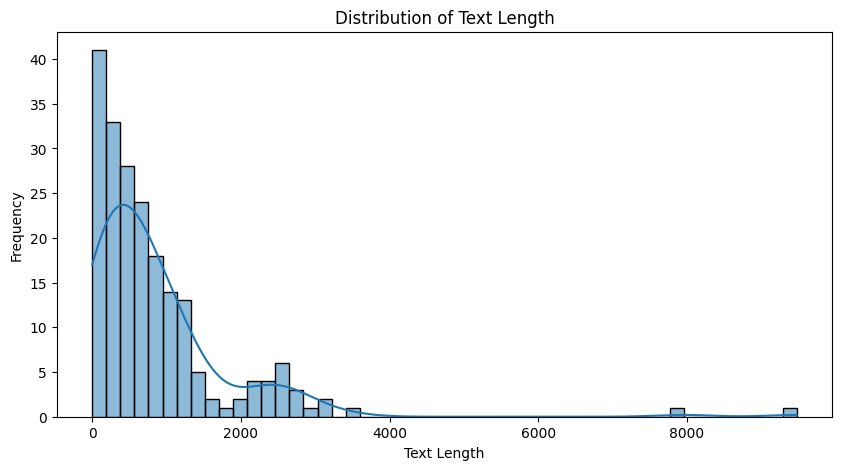

In [12]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated data (before summary statistics)
pcos_df = pd.read_json("pcos_data_with_sentiment.json")
thyroid_df = pd.read_json("thyroid_data_with_sentiment.json")

# Combine the dataframes for analysis
data = pd.concat([pcos_df, thyroid_df], ignore_index=True)

# Ensure 'selftext' column exists and fill missing values
data['selftext'] = data.get('selftext', '').fillna('')
# Text Length Analysis
data['text_length'] = data['selftext'].apply(len)

# Print basic statistics for text length
print("Text Length Statistics:")
print(data['text_length'].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Word Frequency for a few samples:
Row 0: [('and', 13), ('.', 11), ('i', 8), ('she', 8), ('pcos', 7), ('to', 7), ('the', 7), (',', 7), ('said', 6), ('for', 6)]
Row 1: [('my', 2), ('legs', 1), ('and', 1), ('hips', 1), ('never', 1), ('going', 1), ('up', 1), ('a', 1), ('size', 1), ('but', 1)]
Row 2: [('.', 9), ('pcos', 4), ('(', 4), ('have', 4), ('and', 4), ('i', 3), (',', 3), (')', 3), ('’', 2), ('were', 2)]
Row 3: [(',', 10), ('that', 7), ('.', 7), ('have', 6), ('i', 6), ('a', 6), ('of', 6), ('to', 5), ('and', 4), ('it', 4)]
Row 4: [('have', 3), ('of', 3), ('pcos', 2), ('and', 2), ('it', 2), ('do', 1), ('you', 1), ('any', 1), ('knowladge', 1), ('advantages', 1)]


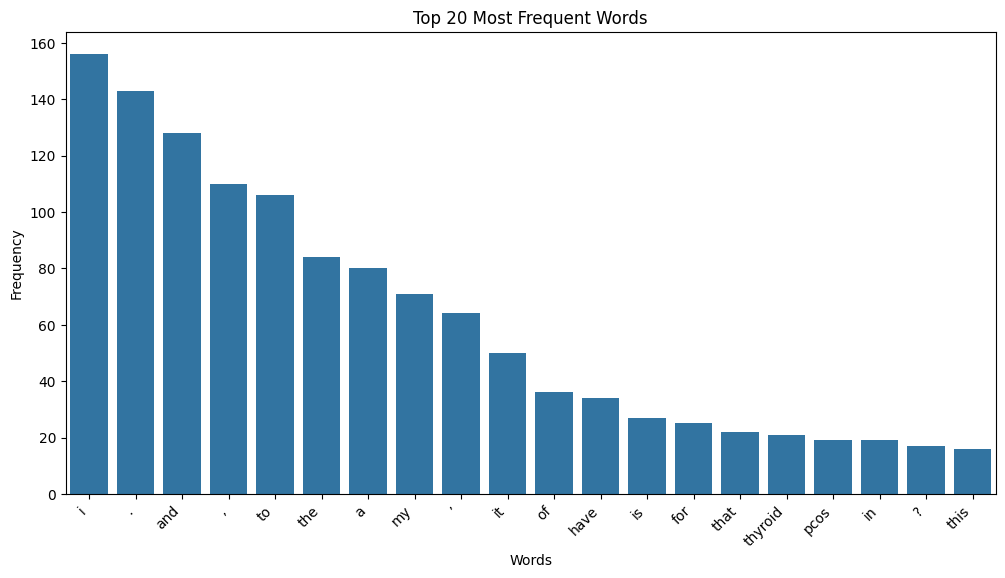

In [14]:
# Word Frequency Analysis
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')  # Download punkt tokenizer if not already downloaded

def analyze_word_frequency(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    fdist = FreqDist(tokens)
    return fdist.most_common(10)  # Get top 10 most frequent words

# Apply word frequency analysis to the 'selftext' column
data['word_frequency'] = data['selftext'].apply(analyze_word_frequency)

# Print word frequency for a few samples
print("\nWord Frequency for a few samples:")
for index in range(5):  # Print for the first 5 rows
    print(f"Row {index}: {data['word_frequency'][index]}")

# Visualize word frequency for the entire dataset (top 20 words)
all_words = []
for row in data['word_frequency']:
    all_words.extend([word for word, freq in row])

fdist_all = FreqDist(all_words)
top_20_words = fdist_all.most_common(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, freq in top_20_words], y=[freq for word, freq in top_20_words])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

## **Data Visualization**

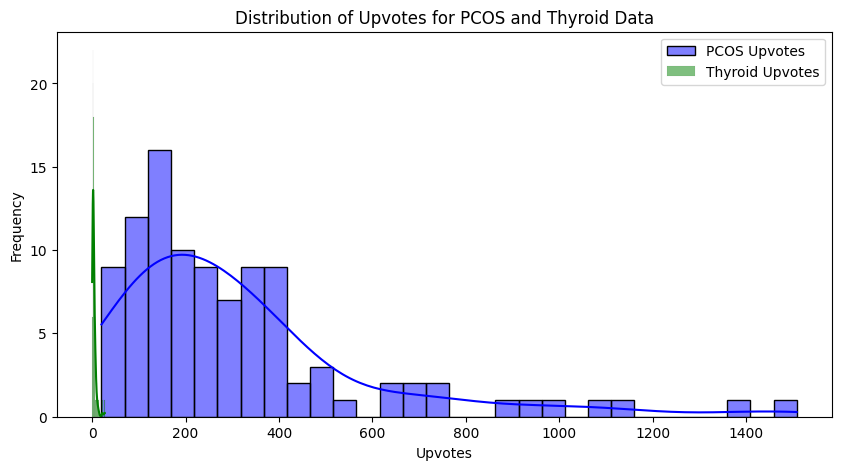

<ipython-input-15-a85365138a1b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=pcos_df, palette="Set2")


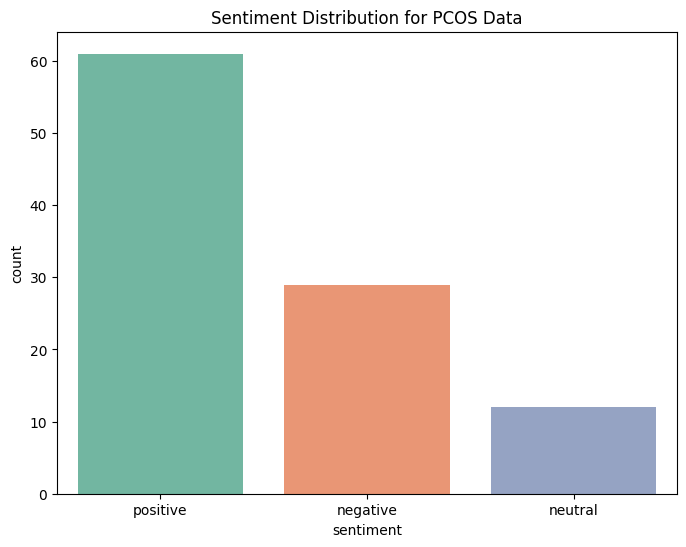

<ipython-input-15-a85365138a1b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=thyroid_df, palette="Set2")


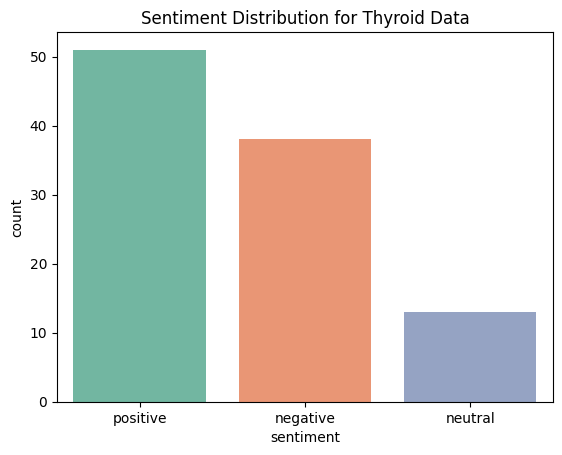

<ipython-input-15-a85365138a1b>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=pcos_df_filtered, palette="Set2", order=pcos_df_filtered['emotion'].value_counts().index)


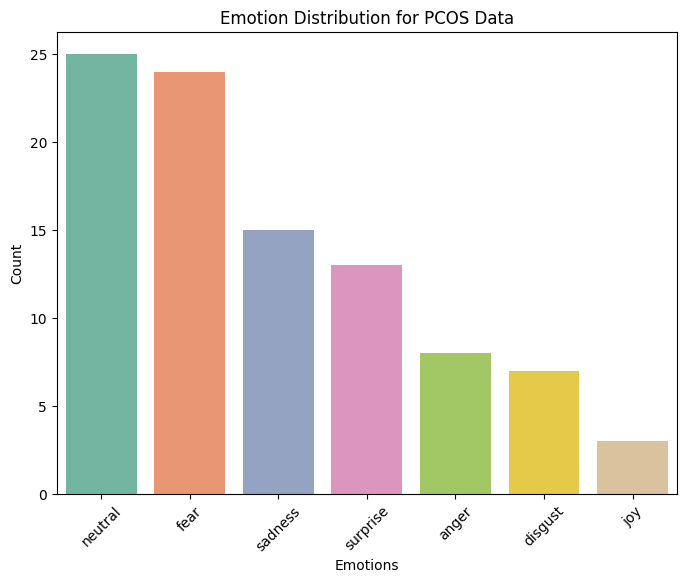

<ipython-input-15-a85365138a1b>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=thyroid_df_filtered, palette="Set2", order=thyroid_df_filtered['emotion'].value_counts().index)


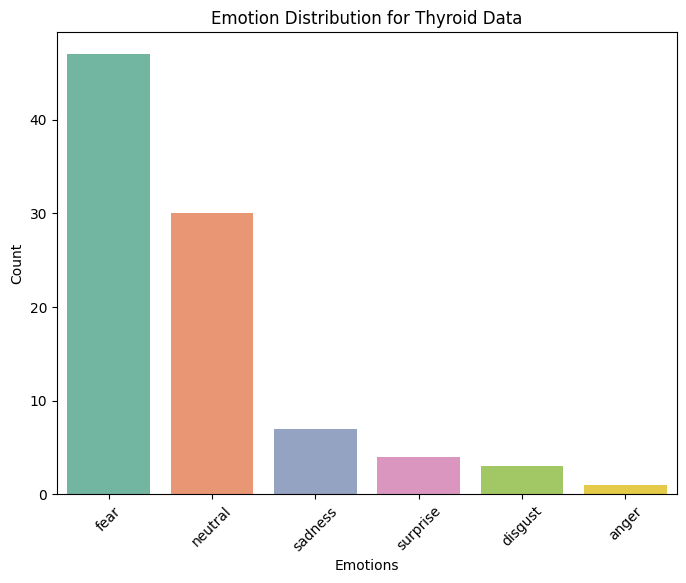

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for upvotes and comments
plt.figure(figsize=(10, 5))
sns.histplot(pcos_df['upvotes'], kde=True, bins=30, color='blue', label="PCOS Upvotes")
sns.histplot(thyroid_df['upvotes'], kde=True, bins=30, color='green', label="Thyroid Upvotes")
plt.legend()
plt.title("Distribution of Upvotes for PCOS and Thyroid Data")
plt.xlabel('Upvotes')
plt.ylabel('Frequency')
plt.show()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=pcos_df, palette="Set2")
plt.title("Sentiment Distribution for PCOS Data")
plt.show()

sns.countplot(x='sentiment', data=thyroid_df, palette="Set2")
plt.title("Sentiment Distribution for Thyroid Data")
plt.show()

# Plot emotion distribution for PCOS data
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion', data=pcos_df_filtered, palette="Set2", order=pcos_df_filtered['emotion'].value_counts().index)
plt.title("Emotion Distribution for PCOS Data")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Plot emotion distribution for Thyroid data
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion', data=thyroid_df_filtered, palette="Set2", order=thyroid_df_filtered['emotion'].value_counts().index)
plt.title("Emotion Distribution for Thyroid Data")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### **Outliers Detection**

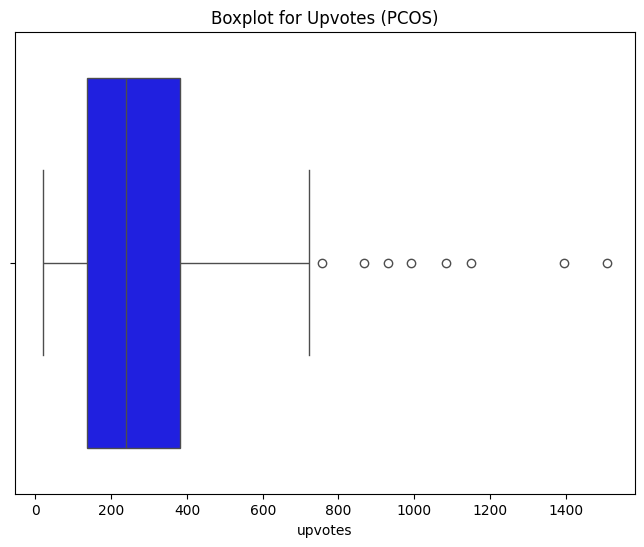

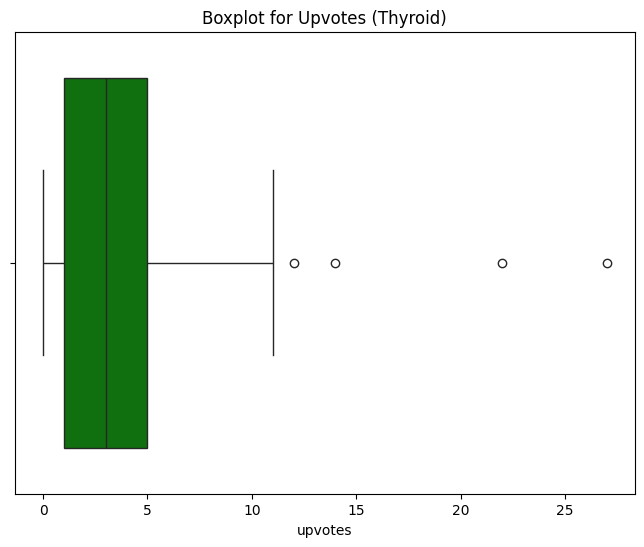

In [16]:
# Using boxplots to detect outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=pcos_df['upvotes'], color='blue')
plt.title("Boxplot for Upvotes (PCOS)")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=thyroid_df['upvotes'], color='green')
plt.title("Boxplot for Upvotes (Thyroid)")
plt.show()

### **Text Similarity Analysis**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Replace None values in 'selftext' with empty strings before applying TfidfVectorizer
pcos_df['selftext'] = pcos_df['selftext'].fillna('')
thyroid_df['selftext'] = thyroid_df['selftext'].fillna('')

# Vectorize the text data for PCOS dataset
vectorizer = TfidfVectorizer(stop_words='english')
pcos_vectors = vectorizer.fit_transform(pcos_df['selftext'])

# Vectorize the text data for Thyroid dataset using the same vectorizer
thyroid_vectors = vectorizer.transform(thyroid_df['selftext'])

# Check the shape of the pcos_vectors matrix
print(pcos_vectors.shape)

# Compute cosine similarity between PCOS and Thyroid vectors
cosine_sim = cosine_similarity(pcos_vectors, thyroid_vectors)

# Print the cosine similarity matrix
print(cosine_sim)



(102, 2534)
[[0.03227297 0.02036781 0.06351673 ... 0.00796671 0.         0.        ]
 [0.04965528 0.         0.06908485 ... 0.         0.         0.        ]
 [0.0130148  0.01812436 0.03560556 ... 0.01913361 0.         0.        ]
 ...
 [0.03053834 0.         0.         ... 0.03771875 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


##**Matching Emotions to Remedies**

In [18]:
# Import necessary libraries
import pandas as pd
from transformers import pipeline

# Load data
pcos_df = pd.read_json("cure_pcos_data.json")
thyroid_df = pd.read_json("cure_thyroid_data.json")
data = pd.concat([pcos_df, thyroid_df], ignore_index=True)

# Fill missing or None values in 'selftext' with an empty string
data['selftext'] = data['selftext'].fillna('')

# Emotion detection pipeline using Hugging Face Transformers
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", truncation=True, max_length=512)

# Function for emotion detection
def detect_emotion(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    result = emotion_analyzer(text)
    return result[0]['label']

# Apply emotion detection to the dataset
data['emotion'] = data['selftext'].apply(detect_emotion)

# Predefined remedies based on emotions
emotion_remedies = {
    'joy': "Maintain a positive outlook and continue healthy habits like exercise and social activities.",
    'sadness': "Consider therapy, meditation, and connecting with supportive friends or family.",
    'anger': "Practice deep breathing, mindfulness, and physical activities to release tension.",
    'fear': "Engage in relaxation techniques, talk to a counselor, and avoid stress triggers.",
    'neutral': "Maintain a balanced lifestyle with regular exercise, sleep, and a healthy diet.",
    'disgust': "Try mindfulness techniques and focus on activities that bring comfort and relaxation.",
    'surprise': "Channel your surprise into curiosity and learning new things."
}

# Function to match emotions to remedies
def match_remedy(emotion):
    return emotion_remedies.get(emotion, "No remedy available for this emotion.")

# Apply the remedy matching function
data['remedy'] = data['emotion'].apply(match_remedy) # Now 'data' DataFrame has 'emotion' column

#**Machine Learning Accuracy Assesment**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Prepare features and labels
X = data['selftext']
y = data['emotion']

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_mapping)

# Check class distribution
print("Class distribution before SMOTE:")
print(y_encoded.value_counts())

# Set k_neighbors dynamically based on the smallest class size
min_class_size = y_encoded.value_counts().min()
k_neighbors = min(3, min_class_size - 1)  # Ensure k_neighbors is less than the smallest class size

# Balance classes with SMOTE
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = smote.fit_resample(X_tfidf, y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Hyperparameter tuning for Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_param_grid = {
    'penalty': ['l2', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}
logreg_grid = GridSearchCV(logreg, logreg_param_grid, cv=3, scoring='accuracy')
logreg_grid.fit(X_train, y_train)
logreg_best = logreg_grid.best_estimator_

# Hyperparameter tuning for SVC
svc = SVC()
svc_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
svc_grid = GridSearchCV(svc, svc_param_grid, cv=3, scoring='accuracy')
svc_grid.fit(X_train, y_train)
svc_best = svc_grid.best_estimator_

# Hyperparameter tuning for XGBoost
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# Evaluate tuned Logistic Regression model
y_pred_logreg = logreg_best.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Evaluate tuned SVC model
y_pred_svc = svc_best.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
print("SVC Accuracy:", svc_accuracy)
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))

# Evaluate tuned XGBoost model
y_pred_xgb = xgb_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Save the results to a new JSON file
data.to_json("data_with_emotions_and_remedies.json", orient="records")
pd.read_json("data_with_emotions_and_remedies.json").to_csv("data_with_emotions_and_remedies.csv", index=False)


Class distribution before SMOTE:
emotion
0    71
6    70
1    22
4    19
2    10
5     9
3     3
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Logistic Regression Accuracy: 0.85
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.64      0.55        14
           1       1.00      0.85      0.92        13
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        20
           6       0.62      0.50      0.55        16

    accuracy                           0.85       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.86      0.85      0.85       100

SVC Accuracy: 0.86
SVC Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.64      0.56        14
           1       1.00      0.85      0.92        13
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        13
      